In [1]:
import pandas as pd

lines = []
scores = []
file_name = "POCA_HalfTrained_lr.log"
#file_name = "POCA_Checkpoint1.log"
with open("../"+file_name, "rt") as fh:
    episode=0
    step=0
    for line in fh:
        if line.startswith("PlayerLog"):
            item = line.strip().replace("PlayerLog: ","").split("position")
            if len(item) == 2:
                agent, coords = item
                x,z,y=coords.strip().replace("is: ","").strip("()").replace(" ","").split(",")
                lines.append([agent.strip(), x, y, (float(x),float(y)), step, episode])
                step+=1
            else:
                if "Scored" in item[0]:
                    scores.append(item[0])
                    episode+=1
                    step=0
                    
                
            

<AxesSubplot:xlabel='x', ylabel='y'>

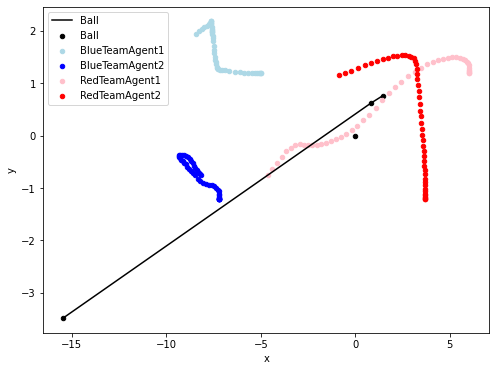

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
df = pd.DataFrame(lines, columns=['agent','x','y','pos','step','episode'])
df = df.set_index("agent")
df['x'] = df['x'].astype(float)
df['y'] = df['y'].astype(float)
df.to_csv(file_name.replace(".log","")+"_AgentGameData.csv")
game = 0
df.query(f"episode == {game}").loc['Ball'].tail(3).plot.line(x="x", y="y", label="Ball", c='black', ax=ax)
df.query(f"episode == {game}").loc['Ball'].plot.scatter(x="x", y="y", label="Ball", c='black', ax=ax)
df.query(f"episode == {game}").loc['Blue Agent1'].plot.scatter(x="x", y="y", label="BlueTeamAgent1", c='lightblue', ax=ax)
df.query(f"episode == {game}").loc['Blue Agent2'].plot.scatter(x="x", y="y", label="BlueTeamAgent2", c='blue', ax=ax)
df.query(f"episode == {game}").loc['Purple Agent1'].plot.scatter(x="x", y="y", label="RedTeamAgent1", c='pink', ax=ax)
df.query(f"episode == {game}").loc['Purple Agent2'].plot.scatter(x="x", y="y", label="RedTeamAgent2", c='red', ax=ax)

In [3]:
import numpy as np

def distance(item):
    pos1, pos2=item[0], item[1]
    return np.sqrt( (pos1[0]-pos2[0])**2 + (pos1[1]-pos2[1])**2)

df_cp = df.copy()
df_cp = df_cp.reset_index()

print(df_cp[df_cp['agent'].isin(['Blue Agent1','Blue Agent2'])].shape)
print(df_cp[df_cp['agent'].isin(['Blue Agent1'])].shape)
print(df_cp[df_cp['agent'].isin(['Blue Agent2'])].shape)
print(df_cp[df_cp['agent'].isin(['Blue Agent1'])].query("episode == 1").shape)
print(df_cp[df_cp['agent'].isin(['Blue Agent2'])].query("episode == 1").shape)

(182962, 6)
(91481, 6)
(91481, 6)
(166, 6)
(166, 6)


In [4]:
blue_distance_dfs = []
purple_distance_dfs = []
for i in range(len(scores)-1):
    episode = i
    ba1_pos = df_cp[df_cp['agent'].isin(['Blue Agent1'])].query(f"episode == {episode}")['pos'].tolist()
    ba2_pos = df_cp[df_cp['agent'].isin(['Blue Agent2'])].query(f"episode == {episode}")['pos'].tolist()
    ra1_pos = df_cp[df_cp['agent'].isin(['Purple Agent1'])].query(f"episode == {episode}")['pos'].tolist()
    ra2_pos = df_cp[df_cp['agent'].isin(['Purple Agent2'])].query(f"episode == {episode}")['pos'].tolist()
    df_blue = pd.DataFrame(list(map(distance, zip(ba1_pos, ba2_pos))),columns=['BlueTeam'])
    df_purple = pd.DataFrame(list(map(distance, zip(ra1_pos, ra2_pos))),columns=['PurpleTeam'])
    if 'Blue' in scores[episode]:
        df_blue['blue_team_scored'] = 1
        df_purple['purple_team_scored'] = 0
    else:
        df_blue['blue_team_scored'] = 0
        df_purple['purple_team_scored'] = 1
    df_blue['episode'] = episode
    df_purple['episode'] = episode
    df_blue.loc[df_blue.shape[0]-1, 'is_final_step'] = 1
    df_purple.loc[df_purple.shape[0]-1, 'is_final_step'] = 1
    blue_distance_dfs.append(df_blue)
    purple_distance_dfs.append(df_purple)
blue_distance_df=pd.concat(blue_distance_dfs)
blue_distance_df = blue_distance_df.fillna(0)
purple_distance_df=pd.concat(purple_distance_dfs)
purple_distance_df = purple_distance_df.fillna(0)

In [5]:
df_distances = pd.DataFrame(range(len(scores)-1), columns=['episode']).merge(purple_distance_df.query("is_final_step == 1").drop(columns=['is_final_step']), how="left")
df_distances = df_distances.merge(blue_distance_df.query("is_final_step == 1").drop(columns=['is_final_step']), how="left")

<AxesSubplot:xlabel='Team', ylabel='distance'>

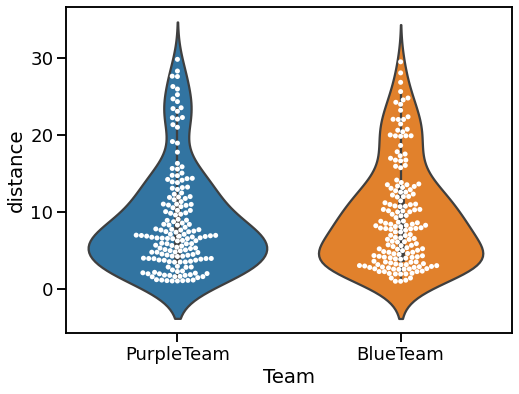

In [24]:
import seaborn as sns
sns.set_context("talk", font_scale=1.1)
df_plot = df_distances.melt(id_vars=['episode','purple_team_scored'], value_vars=['PurpleTeam','BlueTeam'], var_name="Team", value_name='distance')
df_plot = df_plot.query("purple_team_scored == 1")  
plt.figure(figsize=(8,6))
sns.violinplot(y='distance', 
                x='Team', 
                data=df_plot)
sns.swarmplot(y='distance', 
                x='Team', 
                data=df_plot, 
                   color="white", edgecolor="gray")

<AxesSubplot:xlabel='Team', ylabel='distance'>

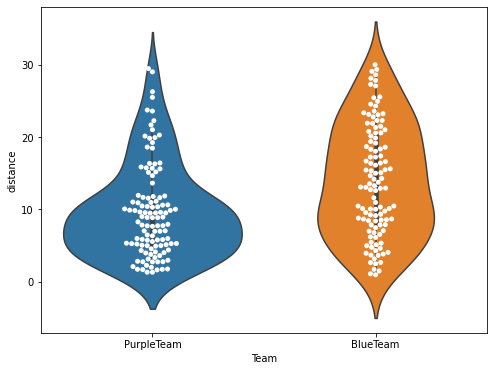

In [7]:
import seaborn as sns
#sns.set_context("talk", font_scale=1.1)
df_plot = df_distances.melt(id_vars=['episode','purple_team_scored'], value_vars=['PurpleTeam','BlueTeam'], var_name="Team", value_name='distance')
df_plot = df_plot.query("purple_team_scored == 0")  
plt.figure(figsize=(8,6))
sns.violinplot(y='distance', 
                x='Team', 
                data=df_plot)
sns.swarmplot(y='distance', 
                x='Team', 
                data=df_plot, 
                   color="white", edgecolor="gray")

array([<AxesSubplot:title={'center':'PurpleTeam'}, xlabel='[purple_team_scored]'>,
       <AxesSubplot:title={'center':'BlueTeam'}, xlabel='[purple_team_scored]'>],
      dtype=object)

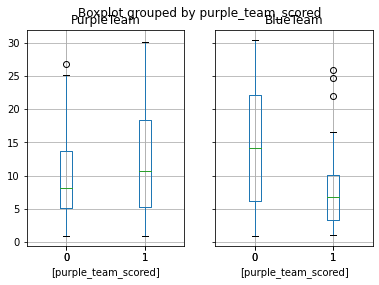

In [241]:
df_distances.boxplot(['PurpleTeam','BlueTeam'], by=['purple_team_scored'])

In [231]:
blue_distance_df.query("blue_team_scored == 1 & is_final_step == 1")

,BlueTeam,blue_team_scored,episode,is_final_step
563,7.020499,1,3,1.0
280,16.616934,1,6,1.0
49,17.090728,1,7,1.0
243,11.318949,1,8,1.0
590,29.690780,1,10,1.0
...,...,...,...,...
293,1.991231,1,258,1.0
75,5.129610,1,259,1.0
43,18.661329,1,261,1.0
105,0.902109,1,262,1.0


In [227]:
blue_distance_df.query("blue_team_scored == 0 & is_final_step == 1")['BlueTeam'].median()

6.763268440628392

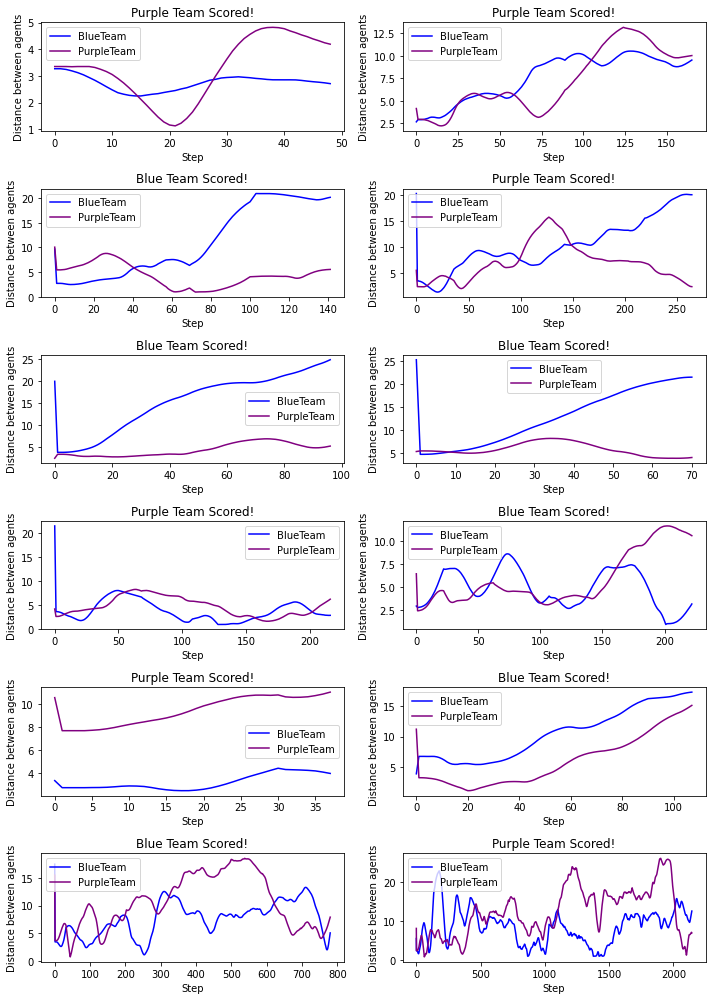

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(10, 14))
for i in range(12):
    c, r = i % 2, i // 2
    episode = i
    ba1_pos = df_cp[df_cp['agent'].isin(['Blue Agent1'])].query(f"episode == {episode}")['pos'].tolist()
    ba2_pos = df_cp[df_cp['agent'].isin(['Blue Agent2'])].query(f"episode == {episode}")['pos'].tolist()
    ra1_pos = df_cp[df_cp['agent'].isin(['Purple Agent1'])].query(f"episode == {episode}")['pos'].tolist()
    ra2_pos = df_cp[df_cp['agent'].isin(['Purple Agent2'])].query(f"episode == {episode}")['pos'].tolist()
    pd.DataFrame(list(map(distance, zip(ba1_pos, ba2_pos))),columns=['BlueTeam']).plot(ax=ax[r][c], c='blue', label='BlueTeam')
    pd.DataFrame(list(map(distance, zip(ra1_pos, ra2_pos))),columns=['PurpleTeam']).plot(ax=ax[r][c], c='purple',  label='PurpleTeam')
    ax[r][c].legend()
    ax[r][c].set_xlabel("Step")
    ax[r][c].set_ylabel("Distance between agents")
    ax[r][c].set_title(scores[episode])
plt.tight_layout()

In [9]:
import skccm as ccm

from skccm.utilities import train_test_split

def embed(x1, x2, lag=3, embed=2):
    e1 = ccm.Embed(x1)
    e2 = ccm.Embed(x2)
    X1 = e1.embed_vectors_1d(lag,embed)
    X2 = e2.embed_vectors_1d(lag,embed)
    return X1, X2

def forecast_skill(embedding, percent=0.75):
    X1, X2 = embedding
    #split the embedded time series 
    x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=percent)

    CCM = ccm.CCM() #initiate the class

    #library lengths to test
    len_tr = len(x1tr)
    lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')

    #test causation
    CCM.fit(x1tr,x2tr)
    x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)

    sc1,sc2 = CCM.score()
    return pd.DataFrame(zip(sc1, sc2), columns=['sc1','sc2'])

results_forecast = []
for episode_n in range(len(scores)-1):
    
    x1 = df.query(f"episode =={episode_n} & agent == 'Blue Agent1'")["x"].values
    x2 = df.query(f"episode == {episode_n} & agent == 'Blue Agent2'")["x"].values
    if len(x1) > 20:
        forecast = forecast_skill(embed(x1, x2))
        max_forecast = forecast.max().max()
        mean_forecast = forecast.mean().max()
        results_forecast.append([episode_n, max_forecast, mean_forecast])

df_results_forecast = pd.DataFrame(results_forecast, columns=['episode', 'max_skill', 'mean_skill'])


/home/vlad/miniconda3/envs/mlagents/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/vlad/miniconda3/envs/mlagents/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/vlad/miniconda3/envs/mlagents/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/vlad/miniconda3/envs/mlagents/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/vlad/miniconda3/envs/mlagents/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/vlad/miniconda3/envs/mlagents/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: in

<AxesSubplot:ylabel='Density'>

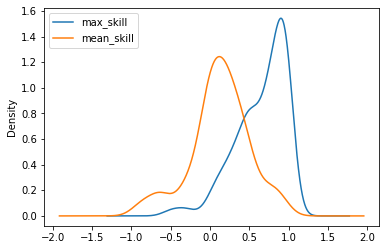

In [10]:
df_results_forecast[['max_skill','mean_skill']].plot.density()

In [14]:
df_results_forecast.describe()

,episode,max_skill,mean_skill
count,268.000000,268.000000,268.000000
mean,140.977612,0.646972,0.123724
std,82.174517,0.321877,0.375974
min,0.000000,-0.539493,-0.949018
25%,70.750000,0.457053,-0.038677
50%,140.500000,0.747240,0.136570
75%,212.250000,0.920442,0.353025
max,282.000000,0.999780,0.985615


In [13]:
df_results_forecast[['max_skill']].mean(), df_results_forecast[['max_skill']].std()

(max_skill    0.646972
 dtype: float64,
 max_skill    0.321877
 dtype: float64)

In [12]:
df_results_forecast[['mean_skill']].mean(), df_results_forecast[['mean_skill']].std()

(mean_skill    0.123724
 dtype: float64,
 mean_skill    0.375974
 dtype: float64)

In [11]:
df_results_forecast[['mean_skill']].median(), df_results_forecast[['mean_skill']].std()

(mean_skill    0.13657
 dtype: float64,
 mean_skill    0.375974
 dtype: float64)